In [1]:
!pip install surprise

     |████████████████████████████████| 11.8MB 245kB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670925 sha256=3e8365f85f6e792c249e891da4f8997d5794c419bd0fe77e00fb7b824a565a44
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [2]:
!pip install implicit

     |████████████████████████████████| 1.1MB 3.4MB/s 
  Created wheel for implicit: filename=implicit-0.4.2-cp36-cp36m-linux_x86_64.whl size=3420054 sha256=00bce2ad6fa9162804163ea2990f2c88d76afdd11118387c72d93dde332bb31b
  Stored in directory: /root/.cache/pip/wheels/1b/48/b1/1aebe3acc3afb5589e72d3e7c3ffc3f637dc4721c1a974dff7
Successfully built implicit


In [3]:
from surprise import Dataset ,Reader, accuracy, SVD, dump
import pandas as pd
import numpy as np
from itertools import chain
from sklearn.utils import shuffle
import pickle
from scipy import sparse
from implicit.als import AlternatingLeastSquares as ALS

In [4]:
# train,val data
tr = pd.read_json("/content/drive/My Drive/Melon-PL-Continuation/0802/train_split/train.json", typ = 'frame')
val = pd.read_json("/content/drive/My Drive/Melon-PL-Continuation/0802/train_split/val.json", typ = 'frame')
# tr['id'] = tr.id.map(str) # surprise에서 inner id와 raw id 사이에 헷갈림 방지

# train playlist를 이용해서 곡 별 태그(new_tags)와 cluster id( PCA + K-means 결과)를 추가한 song_meta
song_meta = pd.read_pickle("/content/drive/My Drive/Melon-PL-Continuation/0802/train_split/song_meta.pkl")
pca = pd.read_pickle("/content/drive/My Drive/Melon-PL-Continuation/0802/train_split/0804_split_pca.pkl")
song_meta['new_song_id'] = pca['MiniBatchKmeans']

In [32]:
tags = pd.unique(list(chain.from_iterable(song_meta.new_tags)))

sid_to_title = dict(pd.Series(song_meta.song_name, index = song_meta.id))
sid_to_cid = dict(zip(song_meta.id, song_meta.new_song_id))
n_clusters = 1000 # k-means cluster 수

tag_to_tid = {tags[i]:n_clusters + i for i in range(len(tags))}
tid_to_tag = {tid:tag for tag,tid in tag_to_tid.items()}

ply_to_title = {tr.id[i]:tr.plylst_title[i] for i in range(len(tr))}

In [ ]:
# cid_to_song(sorted by frequency)
song_freq = pd.DataFrame(pd.Series(chain.from_iterable(tr.songs)).value_counts(), columns = ["freq"])
ong_freq['cid'] = [sid_to_cid[i] for i in song_freq.index.tolist()]
song_freq_dict = dict(song_freq.sort_values(['cid','freq'], ascending=False).groupby('cid').apply(lambda x:x.index.tolist()))

In [6]:
print("총 태그 수 :",len(tags))

총 태그 수 : 112


In [7]:
tr['cid'] = tr.songs.map(lambda x:[sid_to_cid[i] for i in x])
tr['tid'] = tr.tags.map(lambda x:[tag_to_tid[i] for i in x if i in tags])
tr['clusters_tags'] = tr.cid + tr.tid
tr

,tags,id,plylst_title,songs,like_cnt,updt_date,cid,tid,clusters_tags
0,"[힐링, 휴식, 밤, 새벽]",147668,To. 힘들고 지친 분들에게,"[663185, 649626, 6855, 188486, 348451, 169945,...",12,2016-06-23 10:06:27.000,"[201, 885, 807, 972, 62, 807, 317, 374, 972, 3...","[1019, 1017, 1032, 1037]","[201, 885, 807, 972, 62, 807, 317, 374, 972, 3..."
1,[팝],50422,130807-7,"[627035, 256438, 603324, 200889, 441319, 21689...",0,2013-08-15 13:17:11.000,"[724, 397, 86, 622, 479, 744, 710, 453, 147, 4...",[1015],"[724, 397, 86, 622, 479, 744, 710, 453, 147, 4..."
2,[뉴에이지],116432,숙면을 위한 슬픈 마음을 달래 줄 피아노,"[129204, 369497, 649743, 344619, 110281, 63266...",23,2015-09-03 16:51:50.000,"[155, 601, 373, 248, 248, 248, 529, 510, 373, ...",[1016],"[155, 601, 373, 248, 248, 248, 529, 510, 373, ..."
3,"[하드락, 록스피릿, 댄스]",55076,당신을 하얗게 불태울 곡들,"[677591, 420396, 104934, 119279, 251988, 58850...",1,2017-01-09 15:41:25.000,"[320, 488, 593, 488, 593, 268, 121, 304, 651, ...",[1055],"[320, 488, 593, 488, 593, 268, 121, 304, 651, ..."
4,"[힐링, 휴식, 기분전환]",125064,[스피커 필수 / HIPHOP] 듣고 있음 꿀렁꿀렁이고 싶은 힙합음악!,"[704455, 694036, 508043, 154933, 57614, 645195...",715,2016-02-22 12:32:50.000,"[462, 770, 817, 817, 553, 770, 605, 948, 817, ...","[1019, 1017, 1006]","[462, 770, 817, 817, 553, 770, 605, 948, 817, ..."
...,...,...,...,...,...,...,...,...,...
92051,"[90년생, 회상, 추억, 좋은노래, 80년생, 옛날노래]",149690,옛날노래 * 좋은노래 8090년생 노래 모음,"[292099, 513963, 174225, 287212, 140444, 62469...",155,2020-01-15 15:15:45.000,"[80, 412, 972, 100, 100, 100, 351, 100, 100, 1...","[1003, 1002]","[80, 412, 972, 100, 100, 100, 351, 100, 100, 1..."
92052,[팝],35004,LOVE 1,"[62596, 359718, 596004, 668790, 291212, 148977...",8,2010-03-23 00:03:00.000,"[111, 55, 384, 154, 949, 107, 280, 377, 515, 9...",[1015],"[111, 55, 384, 154, 949, 107, 280, 377, 515, 9..."
92053,"[여행, 발라드, 기분전환, 사랑]",59765,추억의 2004년 발라드 베스트,"[214372, 145150, 407082, 160552, 102445, 50845...",3,2019-05-15 13:26:07.000,"[958, 822, 465, 66, 885, 791, 262, 62, 618, 14...","[1014, 1021, 1006, 1029]","[958, 822, 465, 66, 885, 791, 262, 62, 618, 14..."
92054,"[소울, 알앤비]",9867,All Music Guide 선정 90s R&B: 1997,"[561958, 397574, 250915, 110345, 426772, 10698...",51,2013-12-24 14:40:01.000,"[177, 196, 128, 514, 177, 945, 126, 868, 514, ...","[1085, 1025]","[177, 196, 128, 514, 177, 945, 126, 868, 514, ..."


In [8]:
def flatten_series(nested_series, index):
    repeated_index = np.repeat(index, nested_series.map(len))
    return pd.DataFrame(chain.from_iterable(nested_series), index = repeated_index)

In [11]:
cl_tg = flatten_series(tr.clusters_tags, tr.id).reset_index().rename(columns = {0:'iid'})
cl_tg = cl_tg.groupby(cl_tg.columns.tolist()).size().reset_index().rename(columns = {0:'rating'})
cl_tg

,id,iid,rating
0,2,25,1
1,2,214,1
2,2,234,1
3,2,282,1
4,2,317,1
...,...,...,...
2207407,153428,806,3
2207408,153428,844,1
2207409,153428,849,1
2207410,153428,859,4


# ratings에 log 취하기

count    2.207412e+06
mean     2.027696e+00
std      3.061181e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      1.800000e+02
Name: rating, dtype: float64

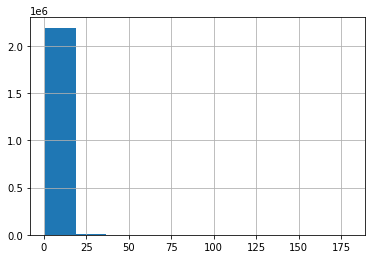

In [18]:
# ratings 분포 체크

cl_tg.rating.hist() 
display(cl_tg.rating.describe())

count    2.207412e+06
mean     1.715656e+00
std      2.116783e-02
min      1.707570e+00
25%      1.707570e+00
50%      1.707570e+00
75%      1.716003e+00
max      2.361728e+00
Name: rating, dtype: float64

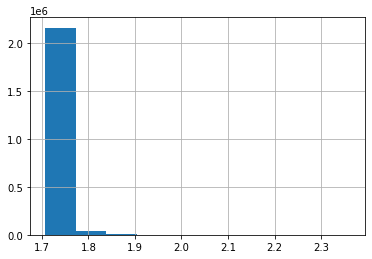

In [81]:
# log하면 괜찮아진다.

import math
log_ratings = cl_tg.rating.map(lambda x: math.log10(x+50))
log_ratings.hist()
display(log_ratings.describe())

In [86]:
cl_tg['index_id'] = cl_tg.id.map(uid_to_index)
cl_tg

,id,iid,rating,index_id
0,2,25,1,1539
1,2,214,1,1539
2,2,234,1,1539
3,2,282,1,1539
4,2,317,1,1539
...,...,...,...,...
2207407,153428,806,3,25745
2207408,153428,844,1,25745
2207409,153428,849,1,25745
2207410,153428,859,4,25745


# CSR matrix 만들기
##### USAGE
```
sparse.coo_matrix(([1,2,3],([1,1,3],[1,2,3]))).todense()
```

* coo_matrix로 만들건데, **indices**를 넣어야함 !!
* clusters + tags는 0~1112의 연속적인 값이니까 ok
* play list id는 단위가 크고 연속도 아니니까 `uid_to_index`를 이용해주자

In [ ]:
uid_to_index = {j:i for i,j in enumerate(tr.id.values)}
index_to_uid = {j:i for i,j in uid_to_index.items()}

In [90]:
user_index = cl_tg.id.map(uid_to_index).values
item_index = cl_tg.iid.values

user_item = sparse.coo_matrix((log_ratings,(user_index, item_index)))

In [91]:
user_item # ply list 총 92056개, clusters+tags 1112개 !

<92056x1112 sparse matrix of type '<class 'numpy.float64'>'
	with 2207412 stored elements in COOrdinate format>

# ALS 방법으로 training [doc](https://implicit.readthedocs.io/en/latest/als.html)  
  
1. ALS model에 `user-item.T` 를 fitting한다.  
  input matrix는 csr 계열이 필요. `csr`, `coo_matrix` 등
2. song model과 tag model을 따로 선언하고
  1. user_factor를 1번 model의 `user-latent` matrix로 할당한다.
  2. item_factors는 1번 모델의 `item-latent` matrix를 slicing해서 할당한다.
3. `recommend` method를 이용해서 추천한다 !  
  알아서 user가 **소비하지 않은 item만** return한다.

##### 1. `user-song+tags` 로 fitting

In [205]:
als_model = ALS(factors = 128, regularization = 0.08, iterations = 15) # use_gpu=True(default), iter 15(default)
als_model.fit(user_item.T*10)

In [206]:
print("user - latent :",als_model.user_factors.shape)
print("item - latent :",als_model.item_factors.shape)

user - latent : (92056, 128)
item - latent : (1112, 128)


##### 2. songs/tags에 각각 ALS model을 선언하고 1에서 생성한 latent matrix를 잘라 각각 user, item에 할당

In [207]:
# songs_model

song_model = ALS()
song_model.user_factors = als_model.user_factors # users-latent
song_model.item_factors = als_model.item_factors[:n_clusters] # songs-latent

# tags_model

tag_model = ALS()
tag_model.user_factors = als_model.user_factors # users-latent
tag_model.item_factors = als_model.item_factors[n_clusters:] # tags-latent

In [208]:
print('songs - latent',als_model.item_factors[:n_clusters].shape)
print('tags - latent',als_model.item_factors[n_clusters:].shape)

songs - latent (1000, 128)
tags - latent (112, 128)


##### 3. recommendation에 이용할 orig matrix를 준비한다.
* als_model_object.recommend에는 user_index, orig_matrix가 필요하다.
* 왜냐 ! 알아서 이미 소비한 item은 빼준다아 

In [209]:
item_rec_csr = user_item.tocsr()[:, :n_clusters]
tag_rec_csr = user_item.tocsr()[:, n_clusters:]

# Recommendation 과정

In [210]:
# user_index.
# true_user_id = index_to_uid[ u = 0 ]

u = 0

### 1. songs

In [211]:
# item_id와 completion 값을 retun한다.
item_rec = song_model.recommend(u, item_rec_csr, N = 10)
item_rec[:10]

[(314, 0.9911565),
 (576, 0.79857147),
 (203, 0.76619726),
 (214, 0.7138728),
 (766, 0.7084738),
 (4, 0.7040316),
 (379, 0.69116616),
 (258, 0.6897136),
 (419, 0.6761359),
 (545, 0.66818047)]

In [212]:
# cluster id에 접근해서 노래 쏙쏙 뽑아보기 ~
item_rec = [song_freq_dict[cid] for cid,score in item_rec]
print(item_rec)

[[349492, 463173, 396828, 42155, 520093, 680366, 485155, 523521, 648628, 422915, 187047, 547967, 422077, 350309, 215411, 442014, 427724, 668128, 582252, 448116, 199262, 235773, 341513, 68348, 209993, 105140, 487911, 509998, 157055, 678762, 15318, 108004, 38261, 690604, 232606, 600802, 698536, 133484, 261659, 402583, 473256, 454890, 182201, 433145, 339077, 616210, 223071, 384848, 78949, 331398, 1513, 653569, 213019, 322543, 2095, 595172, 194435, 423594, 580786, 36179, 576250, 221695, 244132, 55358, 640753, 417565, 541943, 119734, 312945, 400432, 495830, 648344, 377036, 116005, 623725, 404774, 606635, 487956, 594335, 426402, 619251, 394661, 301862, 309947, 247121, 76798, 229487, 468331, 617926, 213699, 75425, 516186, 183616, 479241, 517996, 285546, 300506, 408772, 142584, 342503, 633780, 30009, 145420, 541670, 77089, 438369, 697696, 126946, 681234, 359758, 690614, 532471, 624047, 139482, 259615, 231274, 397265, 692782, 451454, 226675, 472255, 406082, 589284, 564698, 270321, 672022, 62263

In [213]:
for ls in item_rec[:5]:
    print([sid_to_title[i] for i in ls][:10])

['어떤이별', '비가 내렸어 (Vocal by 스티브언니)', '쉬운사랑', '벙어리', '고마운 사람 (Vocal by 이소진)', '끝내지 못한 이야기 (Feat. 호수)', '선물', '사랑을 놓치고', '분홍빛 가득한 날에 (Vocal by 호수)', '연인']
['돈으로 주세요', 'Jungle In Your Mind', '빨간 피터', '맑음 때때로 흐리고 비', '널 불러보는 말 (With 김종완 Of NELL)', '스모우크핫커피리필', '술 한잔해', '베란다', '북극곰', '의식의흐름']
['My Heart Will Go On (Love Theme)', 'I Could Give You Love', 'Reality', 'Ship And The Globe', 'Coming Up Roses', 'True Romance (엔딩 테마)', '봄날은 간다', 'You`re My Best Friend', 'You Are Everywhere', 'Gentle Rain']
['다시', '보고싶어', '그런 너', '사실', 'Feeling', '우리 이렇게', '4년전 5월 그때의 우리', '사랑해라 나를', '잔인한 사월', '그 어떤 말로도 (Feat. 장윤주)']
['크리스마스', 'Izaura', 'Comment Te Dire Adieu It Hurts To Say Goodbye', 'Non Je Ne Regrette Rien', '출격', 'Sweet Amore (Feat. 프롬)', '너를 선택한다', '떠나지 못할 이유는 없었다는 걸', 'November Rain (Original By Gunz`N Roses)', 'She`s A Star']


### 2. tags

In [214]:
tag_rec = tag_model.recommend(u, tag_rec_csr, N=10)
tag_rec = [tid_to_tag[n_clusters + tid] for tid,score in tag_rec]
print(tag_rec)

['감성', '명곡', '추억', '회상', '퇴근길', '댄스', '분위기', '까페', '노래', '비오는날']


In [215]:
# gt
tr.query(f'id=={index_to_uid[0]}')

,tags,id,plylst_title,songs,like_cnt,updt_date,cid,tid,clusters_tags
0,"[힐링, 휴식, 밤, 새벽]",147668,To. 힘들고 지친 분들에게,"[663185, 649626, 6855, 188486, 348451, 169945,...",12,2016-06-23 10:06:27.000,"[201, 885, 807, 972, 62, 807, 317, 374, 972, 3...","[1019, 1017, 1032, 1037]","[201, 885, 807, 972, 62, 807, 317, 374, 972, 3..."


In [240]:
def recommendation_preview(user_id):
    user_index = uid_to_index[user_id]

    # ground truth
    print("● Grount truth\n")
    gt = tr.query(f'id=={user_id}')
    display(gt)
    print("\n","\t".join([sid_to_title[i] for i in gt.songs.values[0]][:30]))
    
    # songs
    item_rec = song_model.recommend(user_index, item_rec_csr, N = 100)
    print("\n● Recommended clusters preview\n")
    for cluster_id, _ in item_rec[:3]:
        display(song_meta.query(f'new_song_id == {cluster_id}').head())

    item_rec = [*chain.from_iterable(song_freq_dict[cid][:int(score*100)] for cid,score in item_rec)][:100]
    print("\n● Recommended songs preview\n")
    print("\t".join([sid_to_title[i] for i in item_rec[:30]]))

    # tags
    print("\n● Recommended tags preview\n")
    tag_rec = tag_model.recommend(user_index, tag_rec_csr, N=10)
    tag_rec = [tid_to_tag[n_clusters + tid] for tid,score in tag_rec]
    print(tag_rec)

In [241]:
recommendation_preview(147668)

● Grount truth



,tags,id,plylst_title,songs,like_cnt,updt_date,cid,tid,clusters_tags
0,"[힐링, 휴식, 밤, 새벽]",147668,To. 힘들고 지친 분들에게,"[663185, 649626, 6855, 188486, 348451, 169945,...",12,2016-06-23 10:06:27.000,"[201, 885, 807, 972, 62, 807, 317, 374, 972, 3...","[1019, 1017, 1032, 1037]","[201, 885, 807, 972, 62, 807, 317, 374, 972, 3..."



 Defying Gravity (Glee Cast Ver.)	형	Going Home	선인장 (Vocal 심규선)	나는 문제 없어	사랑한다는 말로도 위로가 되지 않는	울지마	요즘 너 말야	부디	수고했어, 오늘도	말하는 대로	Airbag (feat. 나얼)	흰수염고래	That`s Nothing	I Won`t Give Up	웃으며 넘길래	Fix You	You Raise Me Up	힘들어 (Feat. 공도하)	한숨	위로	나를 외치다	With Or Without You	같이 걸을까	우울한 너에게	아버지	두 손, 너에게 (Feat. 최백호)	바보처럼 살았군요	걱정말아요 그대	혼자 두지 마

● Recommended clusters preview



,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id,new_tags,new_song_id
54,[GN0101],20190408,있어줄래,10271322,[500421],있어줄래,[GN0100],[길구봉구],54,"[잔잔한, 감성, 밤, 새벽, 발라드, 위로, 힐링, 기분전환, 출근길, 매장음악,...",314
1513,"[GN0105, GN0101]",20180313,듣고 있니,10146980,[1956715],듣고 있니,[GN0100],[러브 포엠],1513,"[어쿠스틱, 여유, 잔잔한, 겨울, 밤, 휴식, 발라드, 새벽, 인디, 따뜻한, 감...",314
2095,"[GN0509, GN0105, GN0101, GN0506, GN0501]",20161229,있잖아 널 사랑해,10027086,[242988],있잖아 널 사랑해,"[GN0500, GN0100]",[정준일],2095,"[달달한, 연애, 고백, 설렘, 사랑, 어쿠스틱, 여유, 잔잔한, 겨울, 밤, 감성...",314
14847,"[GN0501, GN0101, GN0506, GN0509]",20180130,I Miss You,10134513,[763813],I Miss You,"[GN0500, GN0100]",[로코베리],14847,"[인디, 잔잔한, 저녁, 발라드, 휴식, 감성, 이별, 매장음악, 카페, 취향저격,...",314
15318,"[GN0105, GN0101]",20171218,With Winter,10120289,[726168],With Winter,[GN0100],[민은서밴드],15318,"[어쿠스틱, 발라드, 우울, 분위기, 드라이브, 산책, 띵곡, 인디, 힐링, 설렘,...",314


,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id,new_tags,new_song_id
1220,"[GN0501, GN0601, GN0503, GN0606, GN0509]",20121008,Dreamtalk,2152066,[100397],스모우크핫커피리필,"[GN0500, GN0600]",[3호선 버터플라이],1220,"[인디, 락, Rock, 새벽, 겨울, 몽환, 달달, 비오는날, 밤, 우울, 기분전...",576
3418,"[GN0509, GN0601, GN0503, GN0606, GN0501]",20131009,12시엔 칼로리가 리셋됩니다,2209448,[547222],12시엔 칼로리가 리셋됩니다,"[GN0500, GN0600]",[인메이],3418,"[매장음악, 까페, 휴식, 힐링, 잔잔한, 스트레스, 운동, 사랑, 기분전환, 밤,...",576
4756,"[GN0501, GN0601, GN0503, GN0606, GN0509]",20190222,YOU`VE NEVER HAD IT SO GOOD,10253772,[723144],비가 오지 않는 밤에,"[GN0500, GN0600]",[로큰롤라디오 (ROCK N ROLL RADIO)],4756,"[인디, 밤, 새벽, 새벽감성, 몽환, 여름, 감성, 휴식, 힐링, 기분전환, 저녁]",576
5085,"[GN0501, GN0601, GN0503, GN0606, GN0509]",20150429,조금은 선명해지게,2316160,[514901],잘됐으면 좋겠어,"[GN0500, GN0600]",[조이엄],5085,"[봄, 설렘, 사랑, 밤, 카페, 인디, 새벽, 잔잔한, 커피, 산책, 이별]",576
5116,"[GN0501, GN0601, GN0503, GN0606, GN0509]",20170609,UNI-VERSE,10069635,[197928],기억의 궁전,"[GN0500, GN0600]",[짙은],5116,"[비오는날, 가을, 드라이브, 카페, 인디, 몽환, 새벽, 추억, 밤, 회상]",576


,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id,new_tags,new_song_id
5695,"[GN1503, GN1501, GN1001]",20030115,Cine Town 2,41580,[28630],Reality (From Movie 라붐),"[GN1500, GN1000]",[Richard Sanderson],5695,"[휴식, 감성, 잔잔한, 명곡, 추억, 드라이브, 팝, Pop, 힐링, 겨울, 기분...",203
6897,"[GN1503, GN1501]",20061218,샬롯의 거미줄 (Charlotte`s Web) OST,336788,[8045],Ordinary Miracle,[GN1500],[Sarah McLachlan],6897,"[겨울, 휴식, 카페, 잔잔한, 새벽, 힐링, 기분전환, 잠들기전, 편안한, 밤, ...",203
8256,"[GN1503, GN1501]",20031008,시네마 천국(영화 속 아름다운 사랑 풍경 그리고 멜로디),33857,[28235],Thank You,[GN1500],[Dido],8256,"[팝, 여행, 사랑, 설렘, 산책, Pop, 비오는날, 감성힙합, 느낌있는, 카페,...",203
12965,"[GN2601, GN2603, GN1501, GN1504]",20061222,소울메이트 OST,337438,[210686],시간이 흐른뒤엔,"[GN2600, GN1500]",[Postino],12965,"[감성, 비오는날, 휴식, 비, 매장음악, 밤, 새벽, 기분전환, 설렘, 사랑, 슬...",203
13046,"[GN1503, GN1501]",20150210,Fifty Shades Of Grey (Original Motion Picture ...,2305411,[27152],I Put A Spell On You (Fifty Shades of Grey) (F...,[GN1500],[Annie Lennox],13046,"[감성, 카페, 새벽, 달달, 휴식, 뉴에이지, 사랑, 잔잔한, OST, 몽환, 기...",203



● Recommended songs preview

어떤이별	비가 내렸어 (Vocal by 스티브언니)	쉬운사랑	벙어리	고마운 사람 (Vocal by 이소진)	끝내지 못한 이야기 (Feat. 호수)	선물	사랑을 놓치고	분홍빛 가득한 날에 (Vocal by 호수)	연인	착각	불안해	너로 가득해	Sad Movie (Vocal by Levi)	지금보다 조금 (Feat. 이원)	내 곁에 있어줘	지워줄게 (Vocal by 스티브언니)	사랑이 그리워	준비된 이별 (With 박은옥)	MOM (겨울나무)	후회 (Feat. 박은옥)	이 노래를 듣게 된다면 (Feat. 이소진)	너가 떠나던날 (With. 박은옥)	손편지 (Vocal 태인)	미련이 남아서	함께 걷던 길 (With 선진)	Midnight (Feat. 민우)	이별의 이유 (Feat. 박은옥)	ALONE (Vocal 김제훈)	꽃잎이 떨어지면 (Feat. 뜨때로)

● Recommended tags preview

['감성', '명곡', '추억', '회상', '퇴근길', '댄스', '분위기', '까페', '노래', '비오는날']


# ● 무엇을 봐볼까용?
* 얘는 train에 대한 추천 !
* 이미 정답 100개/10가 다 들어있는 상태에서 새롭게 추천해주는 것 !
* 지금도 충분히 잘하고 있으므로 일부만 보고 100/10개 맞추는 task 역시 잘 할 것으로 예상 ㅎㅎ

In [242]:
tags

array(['비오는날', '드라이브', '추억', '회상', '클럽', '매장음악', '기분전환', '스트레스', '신나는',
       '운동', 'EDM', '일렉', '감성', 'Pop', '여행', '팝', '뉴에이지', '휴식', '재즈',
       '힐링', '락', '발라드', '클래식', '산책', '위로', '알앤비', '그루브', '편안한', '연주곡',
       '사랑', '이별', '여름', '밤', '힙합', '겨울', '까페', '잔잔한', '새벽', '오후', '집중',
       '노동요', '주말', '독서', '카페', '인디', '아침', '분위기', '몽환', '공부', 'Jazz',
       '인디음악', 'HipHop', '일상', '트렌디', '걸그룹', '댄스', '아이돌', '노래', '우울',
       '따뜻한', '어쿠스틱', '여름밤', '슬픔', '가을', '비', '눈물', '혼자', '새벽감성', '크리스마스',
       '캐롤', 'JPOP', '가요', '봄', '여유', '감각적인', 'OST', '취향저격', '설렘', '달달',
       '명곡', '기분좋은', '트로트', '팝송', '띵곡', 'RnB', '소울', '록', 'Rock', '랩',
       '카페음악', '감성힙합', '출근길', 'CCM', '저녁', '센치', '연애', '느낌있는', '달달한',
       '자장가', '커피', '고백', '퇴근길', '연인', '잠들기전', '매장', '노래방', '그리움',
       '일렉트로니카', '피아노', '음색', 'electronica', '시원한'], dtype=object)

In [243]:
sorted_idx = tr.tid.map(len).sort_values().index.tolist()

In [244]:
tr.iloc[sorted_idx][tr.iloc[sorted_idx].tags.map(lambda x: "연인" in x)].tail(10)

,tags,id,plylst_title,songs,like_cnt,updt_date,cid,tid,clusters_tags
46986,"[겨울, 가을, 카페, 발라드, 연인, 사랑, 이별, 인디, 어쿠스틱]",149339,주말에 즐겨듣는 발라드 모음.,"[471610, 600417, 85686, 154026, 273178, 531214...",1,2017-11-20 08:07:02.000,"[486, 38, 752, 355, 864, 390, 101, 45, 465, 75...","[1034, 1063, 1043, 1021, 1102, 1029, 1030, 104...","[486, 38, 752, 355, 864, 390, 101, 45, 465, 75..."
13650,"[감성, 봄, 운동, 연인, 드라이브, 기분전환, 설렘, 사랑, 스트레스]",133658,봄향기 느끼며 두근두근할때,"[173798, 376126, 132994, 231078, 53369, 250, 5...",8,2020-04-22 17:44:35.000,"[374, 407, 807, 237, 80, 972, 917, 963, 660, 4...","[1012, 1072, 1009, 1102, 1001, 1006, 1077, 102...","[374, 407, 807, 237, 80, 972, 917, 963, 660, 4..."
18784,"[기분좋은, 매장음악, 카페, 주말, 연인, 행복, 고백, 설렘, 사랑, 달달]",81585,들을수록 기분좋은 달콤한 멜로디,"[263857, 584775, 76591, 36623, 157592, 63825, ...",0,2020-01-28 08:41:33.000,"[963, 963, 963, 972, 963, 963, 516, 807, 959, ...","[1080, 1005, 1043, 1041, 1102, 1100, 1077, 102...","[963, 963, 963, 972, 963, 963, 516, 807, 959, ..."
63263,"[비오는날, 카페음악, 매장음악, 밤, 카페, 새벽, 새벽감성, 연인, 이별]",123134,새벽 감성 이곡이면 끝나요!,"[603835, 376358, 508233, 435017, 235522, 43842...",5,2017-03-16 12:10:21.000,"[808, 407, 646, 646, 808, 80, 80, 262, 972, 46...","[1000, 1089, 1005, 1032, 1043, 1037, 1067, 110...","[808, 407, 646, 646, 808, 80, 80, 262, 972, 46..."
19273,"[기분좋은, 카페, 연인, 매장, 고백, 설렘, 사랑, 달달, 인디, 달콤한]",33020,이어폰 나눠 끼고 즐기는 달콤한 음악 한조각,"[396233, 201186, 39990, 607415, 162615, 570482...",1,2019-08-12 08:32:46.000,"[374, 489, 959, 959, 959, 489, 489, 374, 911, ...","[1080, 1043, 1102, 1104, 1100, 1077, 1029, 107...","[374, 489, 959, 959, 959, 489, 489, 374, 911, ..."
90200,"[감성, 가을, 발라드, 새벽감성, RnB, 연인, 추억, 사랑, 분위기]",139956,강이와 가을이 만나면,"[470286, 541420, 326015, 707724, 471509, 10359...",8,2017-09-02 01:47:48.000,"[311, 465, 588, 972, 681, 147, 154, 504, 147, ...","[1012, 1063, 1021, 1067, 1084, 1102, 1002, 102...","[311, 465, 588, 972, 681, 147, 154, 504, 147, ..."
76915,"[감성, 눈물, 카페, 새벽, 연인, 명곡, 그리움, 사랑, 팝, 따뜻한]",60200,달달한 로맨틱 팝송,"[255937, 309245, 336013, 426804, 676869, 38174...",10,2016-11-30 07:45:27.000,"[147, 147, 282, 588, 588, 588, 147, 282, 282, ...","[1012, 1065, 1043, 1037, 1102, 1079, 1106, 102...","[147, 147, 282, 588, 588, 588, 147, 282, 282, ..."
71131,"[분위기, 매장음악, 밤, 카페, 새벽, 연인, 매장, 드라이브, 기분전환, 팝]",36643,야간 드라이브할 때 베이스 빵빵한 스피커로 듣고 싶은 섹시한 팝,"[310116, 48233, 495814, 677342, 141532, 346207...",3270,2019-09-01 06:00:21.000,"[588, 860, 997, 456, 789, 860, 551, 301, 551, ...","[1046, 1005, 1032, 1043, 1037, 1102, 1104, 100...","[588, 860, 997, 456, 789, 860, 551, 301, 551, ..."
48440,"[겨울, 감성, 밤, 발라드, 연인, 잔잔한, 휴식, 사랑, 이별, 인디]",72970,연인과 함께 듣고싶음 따스한 발라드,"[217217, 389643, 457500, 707564, 338994, 78949...",1,2020-02-07 09:26:03.000,"[705, 705, 465, 972, 887, 314, 972, 314, 314, ...","[1034, 1012, 1032, 1021, 1102, 1036, 1017, 102...","[705, 705, 465, 972, 887, 314, 972, 314, 314, ..."
81325,"[겨울, 휴식, 매장음악, 어쿠스틱, 카페, 발라드, 연인, 사랑, 이별, 인디]",37954,겨울 카페에 어울리는 발라드.,"[600074, 252347, 353211, 640657, 134523, 32332...",2,2017-11-22 09:00:06.000,"[465, 465, 147, 751, 972, 28, 45, 911, 314, 45...","[1034, 1017, 1005, 1060, 1043, 1021, 1102, 102...","[465, 465, 147, 751, 972, 28, 45, 911, 314, 45..."


In [245]:
tr.iloc[sorted_idx][tr.iloc[sorted_idx].tags.map(lambda x: "힙합" in x)].tail(10)

,tags,id,plylst_title,songs,like_cnt,updt_date,cid,tid,clusters_tags
17858,"[힙합, 겨울, 감성, 카페, 가을, 스트레스, 매장, 드라이브, 기분전환, 팝]",82631,ㄴㅓ 힙합 좋아하는구나?,"[411756, 184540, 439190, 367459, 156278, 23230...",20,2017-07-06 16:06:32.000,"[916, 526, 66, 656, 897, 916, 260, 550, 66, 55...","[1033, 1034, 1012, 1043, 1063, 1007, 1104, 100...","[916, 526, 66, 656, 897, 916, 260, 550, 66, 55..."
77864,"[힙합, 감성, 매장음악, 카페, 알앤비, 운동, 드라이브, 여행, 소울, 신나는]",127920,여심저격 대중가요&힙합,"[289625, 489491, 386424, 384786, 382764, 44215...",7,2019-05-08 14:44:33.000,"[147, 486, 656, 147, 656, 238, 486, 350, 486, ...","[1033, 1012, 1005, 1043, 1025, 1009, 1001, 101...","[147, 486, 656, 147, 656, 238, 486, 350, 486, ..."
60488,"[힙합, 감성, 매장음악, 카페, 알앤비, 운동, 드라이브, 여행, 기분전환, 신나는]",10697,느낌이 오는 것만 담은 Playlist(힙합&알앤비),"[509511, 441977, 635450, 550948, 20502, 2230, ...",12,2019-05-24 05:34:07.000,"[350, 586, 586, 875, 730, 147, 588, 174, 875, ...","[1033, 1012, 1005, 1043, 1025, 1009, 1001, 101...","[350, 586, 586, 875, 730, 147, 588, 174, 875, ..."
50659,"[힙합, 클럽, 랩, 댄스, 드라이브, 여행, 기분전환, 사랑, 트렌디, 팝]",115404,흑누나가 꼬시면 꼼짝못해~,"[616332, 58843, 521067, 462298, 228762, 372976...",10,2018-01-19 19:38:18.000,"[359, 770, 384, 813, 869, 882, 813, 384, 311, ...","[1033, 1004, 1088, 1055, 1001, 1014, 1006, 102...","[359, 770, 384, 813, 869, 882, 813, 384, 311, ..."
32566,"[힙합, 감성, 매장음악, 카페, 알앤비, 운동, 드라이브, 여행, 사랑, 신나는]",145369,믿고 듣는 힙합&알앤비,"[675759, 297009, 588063, 342775, 481390, 50951...",3,2020-01-30 14:26:36.000,"[710, 486, 147, 486, 147, 350, 916, 598, 133, ...","[1033, 1012, 1005, 1043, 1025, 1009, 1001, 101...","[710, 486, 147, 486, 147, 350, 916, 598, 133, ..."
22583,"[힙합, 겨울, 감성힙합, 봄, 드라이브, 여행, 감성, 기분전환, 사랑, 신나는]",87937,트렌디한 겨울밤 감성힙합!!,"[175944, 689543, 618150, 664391, 274716, 23560...",3710,2019-12-13 22:14:17.000,"[897, 732, 237, 905, 237, 732, 897, 237, 246, ...","[1033, 1034, 1090, 1072, 1001, 1014, 1012, 100...","[897, 732, 237, 905, 237, 732, 897, 237, 246, ..."
6073,"[힙합, 감성, 가을, 잔잔한, 새벽, 드라이브, 여행, 휴식, 기분전환, 힐링]",9228,#가을#감성힙합#여심저격#,"[64605, 462857, 412063, 416182, 680152, 701463...",11,2018-08-21 15:11:37.000,"[101, 905, 958, 772, 708, 623, 147, 496, 677, ...","[1033, 1012, 1063, 1036, 1037, 1001, 1014, 101...","[101, 905, 958, 772, 708, 623, 147, 496, 677, ..."
85307,"[힙합, 감성힙합, 새벽, 취향저격, 우울, 그루브, 감성, 트렌디, 사랑, 힐링]",138187,이거 누구 노래야?물어보게 만드는 #나만 알고 싶은 갬성 플레이리스트,"[479005, 597312, 497935, 566081, 563502, 64873...",2,2020-04-22 21:28:16.000,"[647, 897, 623, 730, 582, 927, 486, 486, 927, ...","[1033, 1090, 1037, 1076, 1058, 1026, 1012, 105...","[647, 897, 623, 730, 582, 927, 486, 486, 927, ..."
39681,"[힙합, 클럽, 매장음악, 밤, 카페, 알앤비, 매장, 여행, 느낌있는, 퇴근길]",31764,카페에서 듣다보면 나도 모르게 리듬타는 노래,"[608743, 136144, 323937, 261507, 253104, 62857...",1,2020-02-21 05:57:23.000,"[238, 238, 550, 238, 656, 238, 550, 238, 238, ...","[1033, 1004, 1005, 1032, 1043, 1025, 1104, 101...","[238, 238, 550, 238, 656, 238, 550, 238, 238, ..."
13721,"[힙합, 여행, 운동, 스트레스, 드라이브, 그루브, EDM, 퇴근길, 팝, 신나는]",47817,퇴근길 신남 터지는 funky EDM팝,"[119053, 58644, 452022, 641456, 38782, 40937, ...",42,2019-08-02 18:19:32.000,"[651, 33, 33, 948, 33, 301, 594, 830, 830, 916...","[1033, 1014, 1009, 1007, 1001, 1026, 1010, 110...","[651, 33, 33, 948, 33, 301, 594, 830, 830, 916..."


In [246]:
tr.iloc[sorted_idx][tr.iloc[sorted_idx].tags.map(lambda x: "공부" in x)].tail(10)

,tags,id,plylst_title,songs,like_cnt,updt_date,cid,tid,clusters_tags
46899,"[휴식, 연주곡, 카페, 잔잔한, Jazz, 재즈, 산책, 공부, 따뜻한, 편안한]",59590,잔잔한 재즈 연주로 채우는 낮과 밤 상관없이 사색을 즐길 시간,"[682400, 187799, 275818, 121031, 240115, 34844...",2731,2018-01-07 14:15:58.000,"[729, 56, 996, 533, 378, 56, 729, 56, 729, 56,...","[1017, 1028, 1043, 1036, 1049, 1018, 1023, 104...","[729, 56, 996, 533, 378, 56, 729, 56, 729, 56,..."
65674,"[카페음악, 휴식, 카페, 연주곡, 매장, OST, 감성, 뉴에이지, 피아노, 공부]",117333,화창한 오후 카페에서 듣는 감성 피아노.,"[177552, 213986, 335116, 68399, 106933, 224568...",2,2019-06-12 10:16:39.000,"[635, 210, 635, 635, 635, 913, 635, 913, 913, ...","[1089, 1017, 1043, 1028, 1104, 1075, 1012, 101...","[635, 210, 635, 635, 635, 913, 635, 913, 913, ..."
13778,"[비오는날, 휴식, 연주곡, 카페, 새벽, 오후, 잔잔한, 힐링, 공부, 따뜻한]",65106,당신의 마음을 녹여줄 따뜻한 커피 같은 연주곡이에요,"[284982, 632305, 174209, 375904, 588950, 51163...",13,2018-05-29 14:21:44.000,"[635, 579, 691, 835, 502, 502, 579, 579, 913, ...","[1000, 1017, 1028, 1043, 1037, 1038, 1036, 101...","[635, 579, 691, 835, 502, 502, 579, 579, 913, ..."
52516,"[휴식, 카페, 잔잔한, 피아노, OST, 클래식, 감성, 뉴에이지, 힐링, 공부]",128659,자주 봤던 드라마를 피아노로 접하다.,"[190358, 150403, 595940, 421674, 292694, 40341...",53,2020-04-06 21:23:03.000,"[816, 816, 816, 652, 510, 816, 652, 816, 510, ...","[1017, 1043, 1036, 1108, 1075, 1022, 1012, 101...","[816, 816, 816, 652, 510, 816, 652, 816, 510, ..."
48564,"[집중, 감성, 매장음악, 연주곡, 독서, 뉴에이지, 설렘, 사랑, 느낌있는, 공부]",134505,독서하거나 공부할때 도움되는 bgm,"[90526, 637270, 90869, 530307, 221260, 504216,...",1,2020-04-22 06:41:45.000,"[579, 635, 579, 579, 579, 635, 579, 913, 579, ...","[1039, 1012, 1005, 1028, 1042, 1016, 1077, 102...","[579, 635, 579, 579, 579, 635, 579, 913, 579, ..."
50794,"[휴식, 봄, 잔잔한, 피아노, 독서, 뉴에이지, 산책, 사랑, 공부, 따뜻한]",6996,•°O따뜻한 봄 햇살 같은 뉴에이지O°•,"[240866, 474540, 135697, 32117, 643070, 565877...",12,2020-04-15 17:28:49.000,"[471, 835, 579, 210, 635, 652, 210, 635, 652, ...","[1017, 1072, 1036, 1108, 1042, 1016, 1023, 102...","[471, 835, 579, 210, 635, 652, 210, 635, 652, ..."
61236,"[휴식, 봄, 카페, 잔잔한, 드라이브, 재즈, 독서, 힐링, 기분전환, 공부]",131019,책 읽을 때 듣기 좋은 봄 느낌 재즈 연주곡,"[473986, 303716, 359655, 96612, 89619, 383183,...",1504,2017-07-14 21:23:32.000,"[724, 378, 729, 724, 555, 536, 579, 555, 56, 5...","[1017, 1072, 1043, 1036, 1001, 1018, 1042, 101...","[724, 378, 729, 724, 555, 536, 579, 555, 56, 5..."
69419,"[집중, 매장음악, 주말, 연주곡, 카페, 피아노, 뉴에이지, 공부, 까페, 봄]",33114,봄이 오는 소리를 알리는 피아노 연주곡들,"[80078, 598269, 643070, 199389, 87434, 412695,...",8,2020-04-04 13:14:35.000,"[471, 648, 635, 579, 913, 579, 579, 579, 635, ...","[1039, 1005, 1041, 1028, 1043, 1108, 1016, 104...","[471, 648, 635, 579, 913, 579, 579, 579, 635, ..."
8801,"[집중, 휴식, 노동요, 카페, 연주곡, 새벽, 오후, 뉴에이지, 자장가, 공부]",16875,집중이나 암기할때 필요한음악,"[599022, 265536, 284982, 20735, 33094, 385423,...",54,2018-08-06 15:52:09.000,"[913, 652, 635, 635, 655, 635, 835, 417, 417, ...","[1039, 1017, 1040, 1043, 1028, 1037, 1038, 101...","[913, 652, 635, 635, 655, 635, 835, 417, 417, ..."
80020,"[집중, 감성, 혼자, 카페, 잔잔한, 새벽, 휴식, 힐링, 공부, 밤]",59970,"※카페집중※ 혼자 힐링하며 집중하고 싶을때, 볼륨 조금 줄이고 듣는 뮤직","[339004, 601916, 532114, 128349, 557045, 61475...",19,2019-04-29 14:43:58.000,"[317, 258, 374, 609, 883, 807, 258, 926, 374, ...","[1039, 1012, 1066, 1043, 1036, 1037, 1017, 101...","[317, 258, 374, 609, 883, 807, 258, 926, 374, ..."


# Prediction example 1 : 감성 새벽 인디

In [247]:
recommendation_preview(12306)

● Grount truth



,tags,id,plylst_title,songs,like_cnt,updt_date,cid,tid,clusters_tags
53796,"[감성, 듣기좋은, 카페, 주말, 새벽, 휴식, 기분전환, 산책, 매장음악, 인디]",12306,편안히 듣기 좋은 잔잔한 인디,"[294591, 517976, 331910, 146848, 523424, 69384...",99,2020-02-20 01:18:57.000,"[794, 80, 885, 807, 807, 45, 807, 807, 496, 97...","[1012, 1043, 1041, 1037, 1017, 1006, 1023, 100...","[794, 80, 885, 807, 807, 45, 807, 807, 496, 97..."



 불면증의 버스	Nostalgia	산들산들	Feel Alright	내가 되었으면	Hocus-Pocus (Feat. 효빈)	백야	미쳤나봐 (With 권정열 Of 10cm)	한번더	너를 그리다	망고	5월의 당신은	이 빗속에 (Acoustic Ver.)	헌터, 운명의 여인을 만나다	안개	내게기대 (Feat. 박세영)	사라지는 계절	컬러풀	봄날에 눈이 부신	만약에 우리	그대도 나와 같다면 (Feat. 송희란)	그대의 의미	비가 오는 날에	빈둥빈둥 (Let`s Just Chill)	스커트가 불어온다	당신이 그대가	November Rain	잘 지내자, 우리	Baby Maybe	우주의 먼지

● Recommended clusters preview



,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id,new_tags,new_song_id
4929,"[GN0501, GN0503, GN0504, GN0509, GN2601, GN0601]",20170315,PIZZA,10046102,[773385],PIZZA (Kai Takahashi Remix),"[GN0500, GN2600, GN0600]",[우효],4929,"[감성, 인디, 새벽, 감각적인, 드라이브, 신나는, 댄스, Pop, 그루브, 가요...",188
9009,"[GN0501, GN0601, GN0503, GN0606, GN0509]",20180812,SURFER,10193488,[1702471],SURFER,"[GN0500, GN0600]",[1415],9009,"[여름, 휴식, 운동, 드라이브, 여행, 힐링, 기분전환, 인디, 사랑, 편안한, ...",188
9371,"[GN0501, GN0601, GN0503, GN0606, GN0509]",20140612,이상기후,2260391,[490940],낯선 열대,"[GN0500, GN0600]",[쏜애플 (THORNAPPLE)],9371,"[인디, 힐링, 휴식, 밤, 새벽, 락, 잔잔한, 여름밤, 산책, 드라이브, 그루브...",188
12761,"[GN0501, GN0601, GN0503, GN0606, GN0509]",20160125,HOME,2663570,[774416],거짓말,"[GN0500, GN0600]",[O.O.O (오오오)],12761,"[힐링, 휴식, 밤, 새벽, 여행, 기분전환, 드라이브, 잔잔한, 감성, 가을, 산...",188
13244,"[GN0501, GN0601, GN0503, GN0606, GN0509]",20180607,Wave,10173445,[1626519],Wave,"[GN0500, GN0600]",[챈스 (Chance)],13244,"[집중, 노동요, 감각적인, 오후, 기분전환, 인디, 취향저격, 인디음악, 록, 밤...",188


,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id,new_tags,new_song_id
96,"[GN0805, GN0801]",20140407,PLAY,2249127,[712452],가르마,[GN0800],[AKMU (악동뮤지션)],96,"[추억, 소울, 알앤비, 감성, 발라드, 슬픔, 위로, 이별, 운동, 설렘, 사랑,...",28
6935,"[GN0105, GN0101]",20141006,Falling In Fall,2284601,[227595],Falling In Love (Duet With 환희),[GN0100],[지아],6935,"[달달한, 사랑, 이별, 슬픔, 밤, 새벽, 드라이브, 매장음악, 설렘, 잔잔한, ...",28
20483,"[GN0205, GN0201]",20120316,조으다 완전 조으다,2093735,[472220],조으다 완전 조으다,[GN0200],[하리],20483,"[힐링, 휴식, 추억, 회상, 설렘, 사랑, 댄스, 여름, 감성, 신나는, 봄, 발...",28
25164,"[GN0104, GN0101]",20090612,우리 결혼했어요,584953,[417791],커플 (Feat. 황정음),[GN0100],[김용준],25164,"[설렘, 사랑, 감성, 잔잔한, 크리스마스, 캐롤, 발라드, 추억, 명곡, 기분전환...",28
27758,"[GN0105, GN0101]",20120418,Lee Seung Gi `The Best`,2113210,[58793],내 여자라니까,[GN0100],[이승기],27758,"[회상, 추억, 힐링, 기분전환, 가요, 이별, 발라드, 연인, 사랑, 슬픔, 스트...",28


,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id,new_tags,new_song_id
1220,"[GN0501, GN0601, GN0503, GN0606, GN0509]",20121008,Dreamtalk,2152066,[100397],스모우크핫커피리필,"[GN0500, GN0600]",[3호선 버터플라이],1220,"[인디, 락, Rock, 새벽, 겨울, 몽환, 달달, 비오는날, 밤, 우울, 기분전...",576
3418,"[GN0509, GN0601, GN0503, GN0606, GN0501]",20131009,12시엔 칼로리가 리셋됩니다,2209448,[547222],12시엔 칼로리가 리셋됩니다,"[GN0500, GN0600]",[인메이],3418,"[매장음악, 까페, 휴식, 힐링, 잔잔한, 스트레스, 운동, 사랑, 기분전환, 밤,...",576
4756,"[GN0501, GN0601, GN0503, GN0606, GN0509]",20190222,YOU`VE NEVER HAD IT SO GOOD,10253772,[723144],비가 오지 않는 밤에,"[GN0500, GN0600]",[로큰롤라디오 (ROCK N ROLL RADIO)],4756,"[인디, 밤, 새벽, 새벽감성, 몽환, 여름, 감성, 휴식, 힐링, 기분전환, 저녁]",576
5085,"[GN0501, GN0601, GN0503, GN0606, GN0509]",20150429,조금은 선명해지게,2316160,[514901],잘됐으면 좋겠어,"[GN0500, GN0600]",[조이엄],5085,"[봄, 설렘, 사랑, 밤, 카페, 인디, 새벽, 잔잔한, 커피, 산책, 이별]",576
5116,"[GN0501, GN0601, GN0503, GN0606, GN0509]",20170609,UNI-VERSE,10069635,[197928],기억의 궁전,"[GN0500, GN0600]",[짙은],5116,"[비오는날, 가을, 드라이브, 카페, 인디, 몽환, 새벽, 추억, 밤, 회상]",576



● Recommended songs preview

큰새	12:00	모두 주세요	집에	Mer	나는 새롭게 떠오른 외로움을 봐요	토요일 밤이 좋아 (Saturday Night Fever)	New Hippie Generation	Panda Bear	시퍼런 봄	ㅋ	파도	HOT FRESH	Camel	탱탱볼	HONG KONG	Do It !	빛 (Light)	SURFER	Fall in Love Again	Good Boy Twist	Night Drive	섬 (Queen of Diamonds)	호랑이	Ticket to the Moon	아름다워(디깅클럽서울 Ver.)	아침	가죽자켓	Island Island	눈이 마주쳤을 때

● Recommended tags preview

['드라이브', '밤', '힐링', '여행', '봄', '잔잔한', '까페', '가을', '매장', '어쿠스틱']


# Prediction example 2 : 연인, 고백, 설렘 사랑, 달달

In [248]:
recommendation_preview(45955)

● Grount truth



,tags,id,plylst_title,songs,like_cnt,updt_date,cid,tid,clusters_tags
72105,"[겨울, 밤, 가을, 연인, 드라이브, 고백, 설렘, 사랑, 달달]",45955,"""나 너 좋아해"" 라고 말하고 싶을 때 듣는 노래","[454250, 424843, 610179, 448682, 501822, 33139...",5,2017-11-01 10:07:51.000,"[751, 516, 374, 122, 972, 314, 822, 331, 635, ...","[1034, 1032, 1063, 1102, 1001, 1100, 1077, 102...","[751, 516, 374, 122, 972, 314, 822, 331, 635, ..."



 편하게 들어 (Feat. 강태우)	사랑이라오	좋다고 말해	REALLY REALLY	이 지금	Love Road	좋은걸 뭐 어떡해	Wanna Be (My Baby)	오키나와의 여름	걔 말고	사랑해	첫사랑이죠	그 애 참 싫다	Beautiful Day	진심이 있어	내편남편	그의 바다

● Recommended clusters preview



,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id,new_tags,new_song_id
5971,"[GN0601, GN0606]",20130318,달을 품은 토끼 Volume 1,2178336,[510447],간식송,[GN0600],[제이레빗(J Rabbit)],5971,"[추억, 매장, 드라이브, 감성, 기분전환, 휴식, 힐링, 잔잔한, 여행, 산책, ...",959
9395,"[GN0501, GN0601, GN0503, GN0606, GN0509]",20140509,Rocoberry,2255191,[763813],좋은 이유,"[GN0500, GN0600]",[로코베리],9395,"[인디, 여행, 사랑, 설렘, 산책, 매장음악, 까페, 기분좋은, 감성, 밤, 달달...",959
23155,"[GN0805, GN0801]",20170316,왜 또 봄이야,10045677,"[695335, 748510, 858236]",왜 또 봄이야,[GN0800],"[차오루, 키썸 (Kisum), 예린 (여자친구)]",23155,"[봄, 기분전환, 스트레스, 드라이브, 따뜻한, 카페, 사랑, 산책, 달달, 설렘,...",959
29114,[GN0201],20090630,두 번째 비,595861,[305169],굿모닝 레이디,[GN0200],[바닐라 어쿠스틱],29114,"[드라이브, 설렘, 사랑, 아침, 기분전환, 일상, 신나는, 락, 힐링, 휴식, 밤...",959
39990,[GN0201],20160421,Dynamic Love,2680297,[499464],Dynamic Love,[GN0200],[박보람],39990,"[달달, 연애, 사랑, 봄, 카페, 매장, 고백, 기분전환, 기분좋은, 취향저격, ...",959


,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id,new_tags,new_song_id
8944,"[GN0203, GN0201]",19970301,후애 (後愛),4324,[1100],배반의 장미,[GN0200],[엄정화],8944,"[댄스, 추억, 사랑, 설렘, 회상, 운동, 발라드, 노래방, 기분전환, 신나는, ...",929
14156,"[GN0203, GN0201]",19960801,터보(Turbo) 2집 `New Sensation`,348449,[100059],Twist King,[GN0200],[터보],14156,"[댄스, 여름, 기분전환, 추억, 사랑, 설렘, 회상, 노동요, 매장음악, 드라이브...",929
16783,[GN0201],20140512,예쁜 속옷,2255050,[482640],예쁜 속옷,[GN0200],[지나],16783,"[댄스, 소울, 알앤비, 일렉, 힐링, 휴식, 기분전환, 봄, 설렘, 사랑, 여름,...",929
21620,"[GN0205, GN0201]",20150930,VIVID,2642436,[629831],너나 잘해,[GN0200],[에일리],21620,"[이별, 여름, 운동, 댄스, 드라이브, 여행, 기분전환, 스트레스, 힐링, 휴식,...",929
22608,"[GN0205, GN0201]",20120105,Neo Spirit,2058986,[433746],마녀가 된 이유,[GN0200],[NS 윤지],22608,"[휴식, 힐링, 설렘, 사랑, 힙합, 랩, 매장음악, 아이돌, 추억, 스트레스, 걸...",929


,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id,new_tags,new_song_id
1313,"[GN2503, GN0205, GN2501, GN2506, GN0201]",20140818,The Fourth Single `나처럼 해봐요`,2275066,[477632],나처럼 해봐요,"[GN2500, GN0200]",[오렌지 캬라멜],1313,"[비오는날, 여름, 여름밤, 걸그룹, 댄스, 스트레스, 드라이브, 기분전환, 운동,...",708
4828,"[GN2503, GN0205, GN2501, GN2506, GN0201]",20141124,Pink LUV,2291986,[534360],Wanna Be,"[GN2500, GN0200]",[Apink (에이핑크)],4828,"[기분전환, 드라이브, 아이돌, 잔잔한, 가요, 신나는, 힐링, 휴식, 감성, 설렘...",708
6274,"[GN2503, GN0205, GN2501, GN2506, GN0201]",20101221,Bad Temper,1111453,[428821],Bad Temper,"[GN2500, GN0200]",[가인],6274,"[RnB, 감성힙합, 운동, 설렘, 사랑, 댄스, 스트레스, 기분전환, 아이돌, 추...",708
6377,"[GN2502, GN2501, GN2506, GN0201]",20150727,Ordinary,2330181,[436981],가져가,"[GN2500, GN0200]",[비스트],6377,"[아이돌, 힐링, 휴식, 잔잔한, 스트레스, 밤, 새벽, 기분전환, 비오는날, 감성...",708
6409,"[GN2502, GN0205, GN2501, GN2506, GN0201]",20190304,I Wanna Be - The 1st Album Repackage,10256412,[614026],I Wanna Be (Feat. 소연 of (여자)아이들),"[GN2500, GN0200]",[키 (KEY)],6409,"[아이돌, 드라이브, 기분전환, 감각적인, 일렉, 여름밤, 명곡, 감성, 봄, 힙합...",708



● Recommended songs preview

칵테일 사랑 (With 신재)	말하고 싶은 게 있어	좋은 이유	봄처럼 내게 와	바야흐로 사랑의 계절	Don`t You Know	왜 또 봄이야	두리두리	너와 나	그대에게선 설렘설렘열매가 열리나봐요	우유보다 커피	BABY	두근두근	Duet	2시의 데이트	티가나	Dynamic Love	심쿵주의보	닮은거래요	누가 그래 (Love Wishes)	Picnic	간식송	Eat Song	Mellow	좋아요	Bike	말랑말랑 (Duet. 이지애)	연애하고 싶어	OMG (Feat. SNK, Monica)	고백 (Feat. 이진우, 조예진 From 루싸이트 토끼)

● Recommended tags preview

['새벽', '연애', '카페', '달달한', '기분좋은', '여행', '봄', '매장', '이별', '감성']


# Prediction example 3 : 힙합, 알앤비, 드라이브, 신나는

In [249]:
recommendation_preview(10697)

● Grount truth



,tags,id,plylst_title,songs,like_cnt,updt_date,cid,tid,clusters_tags
60488,"[힙합, 감성, 매장음악, 카페, 알앤비, 운동, 드라이브, 여행, 기분전환, 신나는]",10697,느낌이 오는 것만 담은 Playlist(힙합&알앤비),"[509511, 441977, 635450, 550948, 20502, 2230, ...",12,2019-05-24 05:34:07.000,"[350, 586, 586, 875, 730, 147, 588, 174, 875, ...","[1033, 1012, 1005, 1043, 1025, 1009, 1001, 101...","[350, 586, 586, 875, 730, 147, 588, 174, 875, ..."



 보고싶어 (Feat. 김낙원 Of 소낙빌)	Bloom	Lucky Strike	That&#39;s OK	사임사임 (Feat. CHANGMO)	삐삐	Trip	Sauce	Whatchamacallit (Feat. Chris Brown)	잠꼬대 (Feat. 오혁)	Sunshine (Feat. Crush)	i (Feat. 서사무엘) (Prod. 기리보이)	하루살이 (feat. 설리, Rad Museum)	풀어 (pour up) (Feat. ZICO)	Cigarette (Feat. Tablo, MISO)	Jocelyn Flores	Off You	미세먼지	Why (Feat. 죠지) (Prod. Slom)	It`s You (Feat. ZICO)	Homebody	Blue Orangeade

● Recommended clusters preview



,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id,new_tags,new_song_id
93,"[GN1301, GN1302]",20171014,Morning After,10094197,[956791],Can`t Wait,[GN1300],[dvsn],93,"[까페, 카페, 새벽감성, RnB, 감성, 매장, 휴식, 새벽, Pop, 트렌디, ...",409
9538,"[GN1301, GN1302]",20170526,Unravel Me,10065312,[1459876],Unravel Me,[GN1300],[Sabrina Claudio],9538,"[감성, 봄, 가을, 취향저격, 드라이브, 잠들기전, 팝, 새벽, 밤, 눈물, 센치...",409
25123,"[GN1301, GN1308, GN1302]",20180913,Sleep (3 A.M.),10203312,[2297643],Sleep (3 A.M.),[GN1300],[Lossapardo],25123,"[비오는날, 새벽, 센치, 우울, 감성, 잔잔한, 락, 인디, 팝송, 기분전환, 자...",409
29351,"[GN1301, GN1308, GN1302]",20180727,Throw A Fit,10184124,[752524],Like I Used To,[GN1300],[Tinashe],29351,"[드라이브, Pop, 기분전환, 트렌디, 힙합, 감성, 매장음악, 카페, 가을, 알...",409
30307,"[GN1301, GN1302]",20170428,Whatever Makes U Happy,10107141,[1221302],Patiently,[GN1300],[JMSN],30307,"[RnB, 휴식, 새벽, 몽환, Pop, 감성, 밤, 느낌있는, 카페, 잔잔한, 저...",409


,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id,new_tags,new_song_id
10895,"[GN1304, GN1301, GN1302]",20171019,FUTURES,10103511,[1958188],Futures,[GN1300],[PREP],10895,"[까페, 카페, 비오는날, 새벽, 센치, 우울, 휴식, 주말, 잔잔한, 오후, 감성...",318
13156,"[GN1301, GN1308, GN1302]",20191004,Superstar,10335114,[779645],Superstar,[GN1300],[Majid Jordan],13156,"[기분전환, 매장음악, 드라이브, 여행, 그루브, 락, 알앤비, 취향저격, 감각적인...",318
23458,"[GN1304, GN1301, GN1308, GN1302]",20190227,Something to Feel,10255292,[2631074],Get to You Again,[GN1300],[Mac Ayres],23458,"[알앤비, RnB, 트렌디, 소울, 감성, 밤, 음색, 휴식, 힐링, 카페, 잔잔한...",318
27019,"[GN1301, GN1308, GN1302]",20190809,F**kin&#39; Love Songs (feat. Ebenezer),10316345,[1134217],F**kin&#39; Love Songs (feat. Ebenezer),[GN1300],[Awa],27019,"[힙합, 매장음악, 카페, 알앤비, 드라이브, HipHop, RnB, 트렌디, Po...",318
34777,"[GN1301, GN1308, GN1302]",20181026,BALLADS 1,10203844,[2019784],YEAH RIGHT,[GN1300],[Joji],34777,"[새벽감성, RnB, 우울, Pop, 출근길, 아침, 취향저격, 추억, 드라이브, ...",318


,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id,new_tags,new_song_id
2780,"[GN0302, GN0301]",20190928,쇼미더머니 8 Final,10333372,[782842],미안해서 미안해 (Feat. 권정열 of 10cm),[GN0300],[펀치넬로 (punchnello)],2780,"[저녁, 매장음악, 밤, 카페, 감각적인, 분위기, 센치, 감성, 기분전환, 트렌디...",238
4422,"[GN0401, GN0402]",20191215,Problem (Feat. pH-1),10364502,[2622476],Problem (Feat. pH-1),[GN0400],[지젤 (Jiselle)],4422,"[겨울, 운동, 취향저격, 드라이브, 여행, 기분전환, 트렌디, 신나는, 감성힙합,...",238
7303,"[GN0302, GN0301]",20200126,BOY,10379635,[873162],BOY,[GN0300],[Kid Milli],7303,"[힙합, 휴식, 느낌있는, 카페, 알앤비, 취향저격, 감각적인, 매장, 트렌디, 밤...",238
8922,"[GN0501, GN0304, GN0505, GN0301]",20180621,SSANGMOON,10177626,[896123],쌍문 (SSANGMOON) (Feat. 이하츠),"[GN0500, GN0300]",[STEN (스텐)],8922,"[겨울, 운동, 취향저격, 드라이브, 여행, 기분전환, 트렌디, 신나는, 봄, 감각...",238
11152,[GN0401],20200121,Can I Heat ?,10377735,[1230183],"남아 (Feat. THAMA, SOLE, 김승민)",[GN0400],[Cosmic Boy],11152,"[저녁, 매장음악, 밤, 카페, 감각적인, 분위기, 센치, 감성, 기분전환, 트렌디...",238



● Recommended songs preview

Kissin&#39; On My Tattoos	Exchange	Confidently Lost	Sky Walker (Feat. Travis Scott)	Gentleman	Hallucinations	Don`t Look Back (Feat. Shownu & So! YoON!)	Somthing`s Missing	Smile More	U	With Me	Could`ve Been (Feat. Bryson Tiller)	Do It Well	Caffeine	Niggas	Let Me Explain	501`s	Let Me In	Me & You	LOVE AGAIN	Sanctuary	Come Over	Moi	Falling	Cheating On Me	Peach Jam	Saved	2	Cold Fire (Feat. DEAN)	Somethin Tells Me

● Recommended tags preview

['소울', '그루브', '잔잔한', '여름', '랩', '스트레스', 'RnB', '트렌디', '감성힙합', '매장']


# Prediction example 4 : 집중, 독서, 공부

In [250]:
recommendation_preview(134505)

● Grount truth



,tags,id,plylst_title,songs,like_cnt,updt_date,cid,tid,clusters_tags
48564,"[집중, 감성, 매장음악, 연주곡, 독서, 뉴에이지, 설렘, 사랑, 느낌있는, 공부]",134505,독서하거나 공부할때 도움되는 bgm,"[90526, 637270, 90869, 530307, 221260, 504216,...",1,2020-04-22 06:41:45.000,"[579, 635, 579, 579, 579, 635, 579, 913, 579, ...","[1039, 1012, 1005, 1028, 1042, 1016, 1077, 102...","[579, 635, 579, 579, 579, 635, 579, 913, 579, ..."



 Stepping On The Rainy Street	Romance	Mint Academy	날 수만 있다면	Homeland Eternal	Thanksgiving	May Be	Butterfly In The Rain	사랑의 인사	Love Affair	Les Jours Tranquilles	Kiss The Rain	True Love	The Whole Nine Yards	Rainbow Bridge	Day By Day	Kazamidori (풍향계)	그대를 만난 날	Summer	자각몽 (自覺夢)	학교가는 길	Close To You	공원에서	Deja Vu Waltz	사랑하는 이들에게	November	Dear Green Field	Urban Forest	Koukon (황혼) (Twilight)	Happy Together

● Recommended clusters preview



,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id,new_tags,new_song_id
1518,"[GN1806, GN1801]",20160930,피아노,10002690,[721438],새벽 편지,[GN1800],[피아노],1518,"[휴식, 봄, 카페, 뉴에이지, 피아노, 분위기, 아침, 감성, 밤, 잔잔한, 위로...",709
5527,[GN1801],20160108,공부할 때 듣는 피아노 연주곡 베스트,2660877,[926376],Another Year,[GN1800],[뉴에이지 감성],5527,"[휴식, 봄, 카페, 뉴에이지, 피아노, 분위기, 아침, 집중, 독서, 클래식, 편...",709
6183,"[GN1806, GN1801]",20160930,피아노,10002690,[721438],Night In The City,[GN1800],[피아노],6183,"[휴식, 봄, 카페, 뉴에이지, 피아노, 분위기, 아침, 집중, 독서, 클래식, 편...",709
7212,[GN1801],20161223,잠 잘때 듣는 감성 피아노 자장가 연주곡 베스트 모음,10025421,[945463],언제가는 (Sea Ver.),[GN1800],[피아노 테라피],7212,"[휴식, 봄, 카페, 뉴에이지, 피아노, 분위기, 아침, 잔잔한, 오후, 잠들기전,...",709
13215,[GN1801],20160108,공부할 때 듣는 피아노 연주곡 베스트,2660877,[926376],사랑한다는 말,[GN1800],[뉴에이지 감성],13215,"[힐링, 뉴에이지, 집중, 휴식, 위로, 편안한, 분위기, 피아노, 연주곡, 카페,...",709


,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id,new_tags,new_song_id
580,"[GN1806, GN1801]",20161128,겨울밤,10018484,[944046],겨울밤,[GN1800],[프링 (Pring)],580,"[밤, 아침, 잔잔한, 추억, 겨울, 자장가, 새벽, 매장음악, 휴식, 카페, 매장...",835
3329,"[GN1806, GN1801]",20160511,"안녕, 하루",2684035,[652411],"안녕, 하루",[GN1800],[정환호],3329,"[휴식, 주말, 연주곡, 잔잔한, 뉴에이지, 산책, 따뜻한, 아침, 분위기, 카페,...",835
10022,[GN1801],20031104,메이세컨,33037,[48260],메이세컨,[GN1800],[메이세컨],10022,"[휴식, 매장음악, 연주곡, 아침, 잔잔한, 오후, 뉴에이지, 힙합, 랩, 감성, ...",835
14446,"[GN1806, GN1803, GN1801]",20140114,Scores Of Piano (피아노 스코어),2226027,[3162],Lake Louise,[GN1800],[Yuhki Kuramoto],14446,"[힐링, 휴식, 밤, 새벽, 아침, 잔잔한, 추억, 겨울, 자장가, 피아노, 독서,...",835
16091,[GN1801],20160513,"뉴에이지 연가 : 비 오는 날의 거리, 추억, 그리고 아름다운 재즈 피아노(Pop ...",2684834,[979102],Close To You,[GN1800],[Romantisch Jazzkapelle],16091,"[휴식, 주말, 오후, Jazz, 재즈, 커피, 피아노, 겨울, 카페, 잔잔한, 새...",835


,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id,new_tags,new_song_id
865,[GN1801],20160419,Glory Of Green,2680163,[923813],Glory Of Green,[GN1800],[아리스],865,"[겨울, 힐링, 가을, 밤, 잔잔한, 새벽, 스트레스, 편안한, 집중, 카페, 공부...",502
3603,[GN1801],20170120,밤노을,10032740,[713816],밤노을,[GN1800],[루바토],3603,"[집중, 독서, 공부, 기분좋은, 휴식, 봄, 매장, 힐링, 피아노, 까페, 자장가...",502
5414,"[GN1806, GN1801]",20160822,피아노 지브리 (Piano Ghibli) (Korea Tour Edition),2705626,[450121],너를 태우고,[GN1800],[Elizabeth Bright],5414,"[여름, 감성, 밤, 연주곡, 새벽, 추억, 독서, 뉴에이지, 피아노, 사랑, 위로...",502
5724,[GN1801],20121224,The Place Dancing With Snow,2170846,[695258],찻잔과 도넛이 춤추는 가게 (Christmas Ver.),[GN1800],[세레노],5724,"[카페, 잔잔한, 뉴에이지, 기분전환, 휴식, 밤, 새벽, 감성, 피아노, 매장, ...",502
6868,"[GN1806, GN1801]",20160516,너의 색으로 물들다,2684910,[476012],너의 색으로 물들다,[GN1800],[신지호],6868,"[집중, 자장가, 뉴에이지, 공부, 휴식, 연주곡, 잠들기전, 편안한, 피아노, 매...",502



● Recommended songs preview

달님에게	밤하늘의 별들처럼	위로가 되었으면	어른들을 위한 자장가	토닥토닥 괜찮아	마음	언젠가 우리가 다시 만난다면	모래성 (Sand Castle)	낯선 바람을 따라	I Remember You	하나미즈키 (Hanamizuki)	봄이 오는 풍경	Fly With The Wind	위로	뉴에이지 힐링의 시간, 추억	쉬고 싶은 나무	무지개를 좇던 아이	조금씩 천천히	명상음악 (조용한 사색)	밤하늘에 쓰는 편지	푸른밤, 내방 창문 너머	밤하늘 그리고 별	사랑	녹턴	명상음악 (휴식의 숲)	Madam Windham Hill	명상음악 (오후의 햇살)	A Long Walk (긴 산책)	소망	토닥토닥

● Recommended tags preview

['카페', '피아노', '분위기', '자장가', '취향저격', '까페', '노동요', '편안한', '감각적인', '위로']
